## TPC3

Pretendemos simular a propagação de ondas sísmicas, na situação simplificada de 1D. A equação de propagação da componente $y$ do deslocamento, $u_y(x,t)$, num meio com densidade $\rho(x)$ e constante elástica $\mu(x)$ é:
$$\rho(x) \frac{\partial^2 u_y}{\partial t^2} = \frac{\partial}{\partial x} \bigg( \mu(x) \frac{\partial u_y}{\partial x}\bigg) + f_y,$$

onde $f_y(x,t)$ é uma força exteriormente aplicada (algo que dá origem a um sismo, como um deslocamento de placas, ou um desmoronamento sub-aquático). Use um método pseudo-espectral à sua escolha. Deve referir a razão da escolha, comparando com outro(s).
Para a força, use a função `ricke`, que se encontra no Moodle, com $f_0$ como frequência central. Como parâmetros use:

| Stretch/Untouched | ProbDistribution |
| :- | :-: |
| $\rho$ | $2500\ kg m^{-3}$ |
| $\mu$  | $2.25 \times 10^{10} kg  m^{-1}s^{-2}$ |
| $f_0$  | $100\ kHz$ |

Como é evidente, deve re-escalar a equação.

Considere condições fronteira de Dirichelet.

Deve submeter, além do código, um pequeno filme, ou conjunto de plots sequenciais, da evolução da perturbação inicial para o caso da alínea (e). Em cada imagem (plot) deve mostrar o tempo e indicar as quantidades representadas.

Cada um deve apresentar apenas trabalho seu. Podem usar as rotinas que coloquei no Moodle, ou outras equivalentes que tenham desenvolvido, mesmo que baseados nalguma fonte (mas devem claramente identificar essa fonte(s)).

a) Escolha um esquema para descretizar a derivada temporal, indicando também que método pretende usar para a evolução temporal. Discuta as vantagens e desvantagens desse método.

Partimos da equação

$$\rho(x) \frac{\partial^2 u_y}{\partial t^2} = \frac{\partial}{\partial x} \bigg( \mu(x) \frac{\partial u_y}{\partial x}\bigg) + f_y,$$

Vamos usar um operador de diferenças finitas de 3 pontos para aproximar as derivadas no tempo. Desse modo, o campo é extrapolado como:

$$
\rho_i\frac{u_{i}^{j+1} - 2u_{i}^{j} + u_{i}^{j-1}}{dt^2}= \frac{\partial}{\partial x}\bigg(\mu(x) \frac{\partial u_y}{\partial x}\bigg)_{i}^{j} + f_{i}^{j}
$$


**NÃO É ISSO, FALAR DO MÉTODO CHEBYCHEV** 

b) Use a rotina `ricker` (ler com cuidado a sua descrição, em particular os argumentos que pede e o respectivo uso, bem como a forma do resultado), de modo a gerar o termo fonte à frequência pretendida.

In [1]:
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
from ricker import ricker

In [83]:

def fonte(rho, mu, f0, nx, tmax):
    # Basic parameters
    # ---------------------------------------------------------------
    #nt = 5000        # number of time steps
    #tmax  = 0.0006
    eps   = 1.4       # stability limit
    isx   = 100
    lw    = 0.7
    ft    = 10
    #f0    = 100000    # 100kHz dominant frequency

    # material parameters
    
    c   = np.sqrt(mu/rho)
    

    # space domain
    xs = np.floor(nx/4)      # source location
    xr = np.floor(nx*0.8)
    x  = np.zeros(nx+1) 
    
    x[:] = np.cos(np.arange(0,nx+1)*np.pi/nx)

    dxmin = min(abs(np.diff(x)))
    dxmax = max(abs(np.diff(x)))
    
    cmax = np.sqrt(np.max(mu)/np.min(rho) )
    
    dt = eps*dxmin/c  # calculate time step from stability criterion
    nt = int(round(tmax/np.max(dt)))

    # source time function
    # ---------------------------------------------------------------
    t = np.arange(1, nt+1)*np.max(dt)  # initialize time axis
    T0 = 1./f0
    tmp = ricker(np.max(dt), T0) ## Termo fonte
    isrc = tmp
    tmp = np.diff(tmp)
    src = np.zeros(nt) 
    src[0:np.size(tmp)] = tmp
    
    #spatial source function
    # ---------------------------------------------------------------
    sigma = 1.5*dxmax
    x0 = x[int(xs)]
    sg = np.exp(-1/sigma**2*(x-x0)**2)
    sg = sg/max(sg)

    
    return src,sg, dxmax, nt, dt


rho=2500.
mu=2.25*10**10 
f0=100000
nx=100
tmax=0.006
src,sg, dxmax, nt, dt =  fonte(rho,mu,f0,nx,tmax)

c) Use um método espectral à sua escolha para discretizar as derivadas espaciais. Discuta os méritos e deméritos do método escolhido. Implemente um código que realize esta discretização.

Foi escolhido o método de chebychev

In [84]:

def cheb(N):
    '''compute D = differentiation matrix, x = Chebyshev grid'''
    if N==0: 
        D = 0.; x = 1.
    else:
        n = arange(0,N+1)
        x = cos(pi*n/N).reshape(N+1,1) 
        c = (hstack(( [2.], ones(N-1), [2.]))*(-1)**n).reshape(N+1,1)
        X = tile(x,(1,N+1))
        dX = X - X.T
        D = dot(c,1./c.T)/(dX+eye(N+1))
        D -= diag(sum(D.T,axis=0))
    
    return D, x.reshape(N+1)


d) Escreva o código que lhe permite evoluir o pacote de ondas no tempo com os ingredientes obtidos nas alíneas anteriores. Teste com os parâmetros da tabela acima, que correspondem a um meio homogéneo (logo, sabe a velocidade de propagação, que é constante em todo o domínio!)

<IPython.core.display.Javascript object>


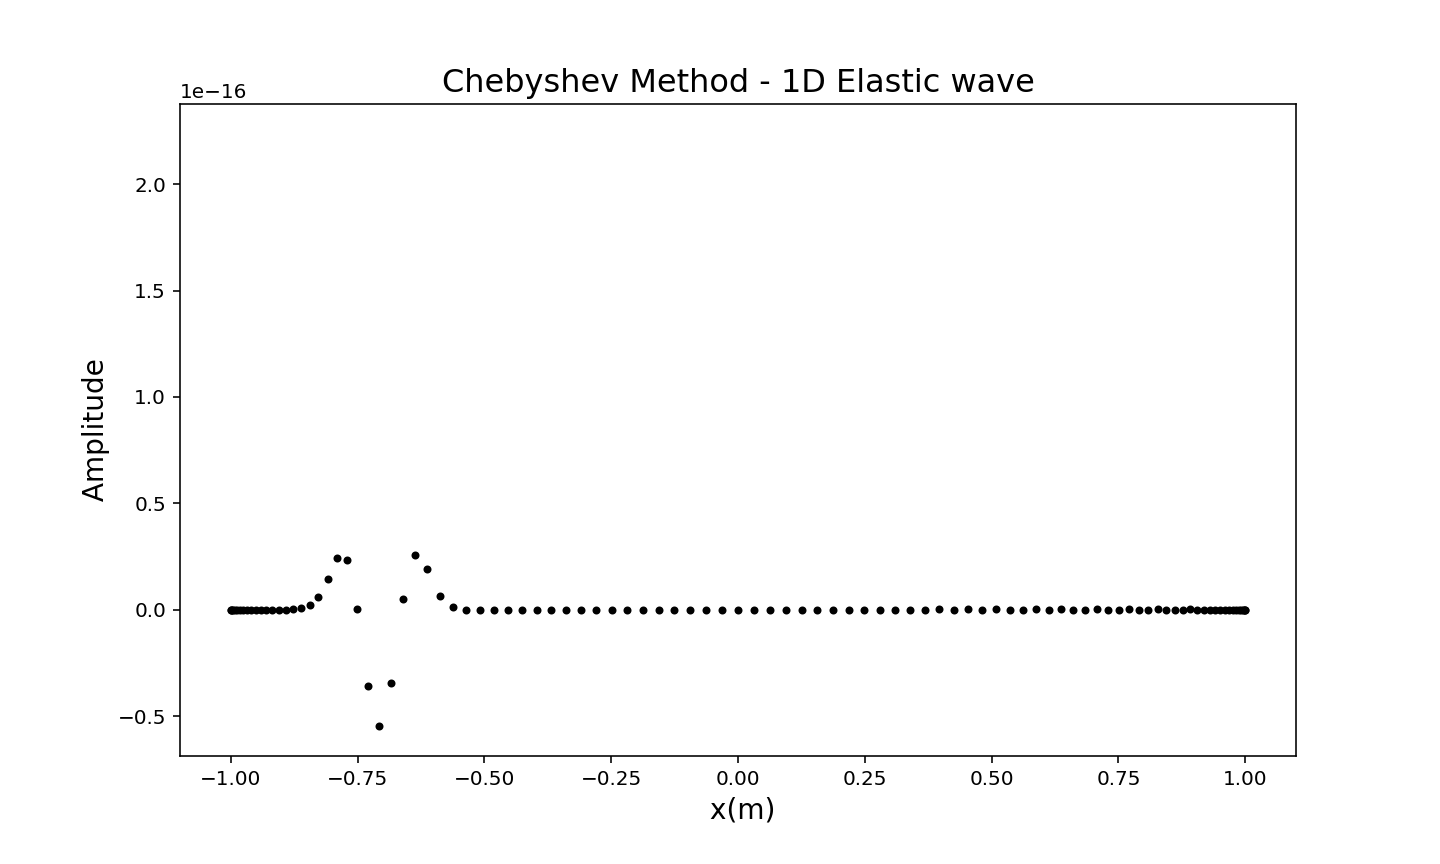

In [85]:
# initialization of pressure fields
p = np.zeros(nx+1) 
pnew = np.zeros(nx+1)
pold = np.zeros(nx+1)
d2p  = np.zeros(nx+1) 


iplot = 20        # Snapshot frequency

# Show the plots in the Notebook.
plt.switch_backend("nbagg")

# Initialize animated plot
# ---------------------------------------------------------------
D,x = cheb(nx)
plt.figure(figsize=(10,6))
line = plt.plot(x, p, 'k.', lw=2)
plt.title('Chebyshev Method - 1D Elastic wave', size=16)
plt.xlabel(' x(m)', size=14)
plt.ylabel(' Amplitude ', size=14)

plt.ion() # set interective mode
plt.show()
# ---------------------------------------------------------------



# Time extrapolation
# ---------------------------------------------------------------
# Differentiation matrix
for it in range(nt):
    # Space derivatives
    dp = np.dot(D, p.T)
    dp = mu/rho * dp
    dp = D @ dp
    
    # Time extrapolation 
    pnew = 2*p - pold + np.transpose(dp) * dt**2
    
    # Source injection
    pnew = pnew + sg*src[it]*dt**2/rho
    
    # Remapping
    pold, p = p, pnew
    p[0] = 0; p[nx] = 0 # set boundaries pressure free 
    
    
    # Animation plot. Display solution
    if not it % iplot: 
        for l in line:
            l.remove()
            del l               
            
        # -------------------------------------- 
        # Display lines
        line = plt.plot(x, p, 'k.', lw=1.5)
        plt.gcf().canvas.draw()

e) Simule a situação de um meio não homogéneo. Considere que as funções $\rho, \mu$ dependem de $x$, variando numa região estreita, de um valor $p_{\textrm{min}}=p_0$ a outro $p_{\textrm{min}}=p_0 + \Delta p \equiv p_1.$ Tome, por exemplo,:
$\rho(x) = (\rho_0 + \rho_1e^{ax})/(1 + e^{ax}),$
onde $a$ é uma constante  positiva, suficientemente grande para fazer que a variação ocorra num intervalo de $5\%$ do seu domínio.(Considere uma expressão semelhante para $\mu$.) Tome $\Delta \rho/ \rho= 0.50$ e $\Delta \mu/ \mu= 0.05.$

In [86]:
r0 = 2500
dr0 = r0/2
a = 20
rhoo = np.array([(r0 + (r0+dr0)*np.exp(a*xx))/(1+np.exp(a*xx)) for xx in x])


mu=2.25*10**10
dmu = mu/20

muu = np.array([(mu + (mu+dmu)*np.exp(a*xx))/(1+np.exp(a*xx)) for xx in x])

In [87]:
src,sg, dxmax, nt, dt =  fonte(rhoo, muu,f0,nx,tmax)

<IPython.core.display.Javascript object>


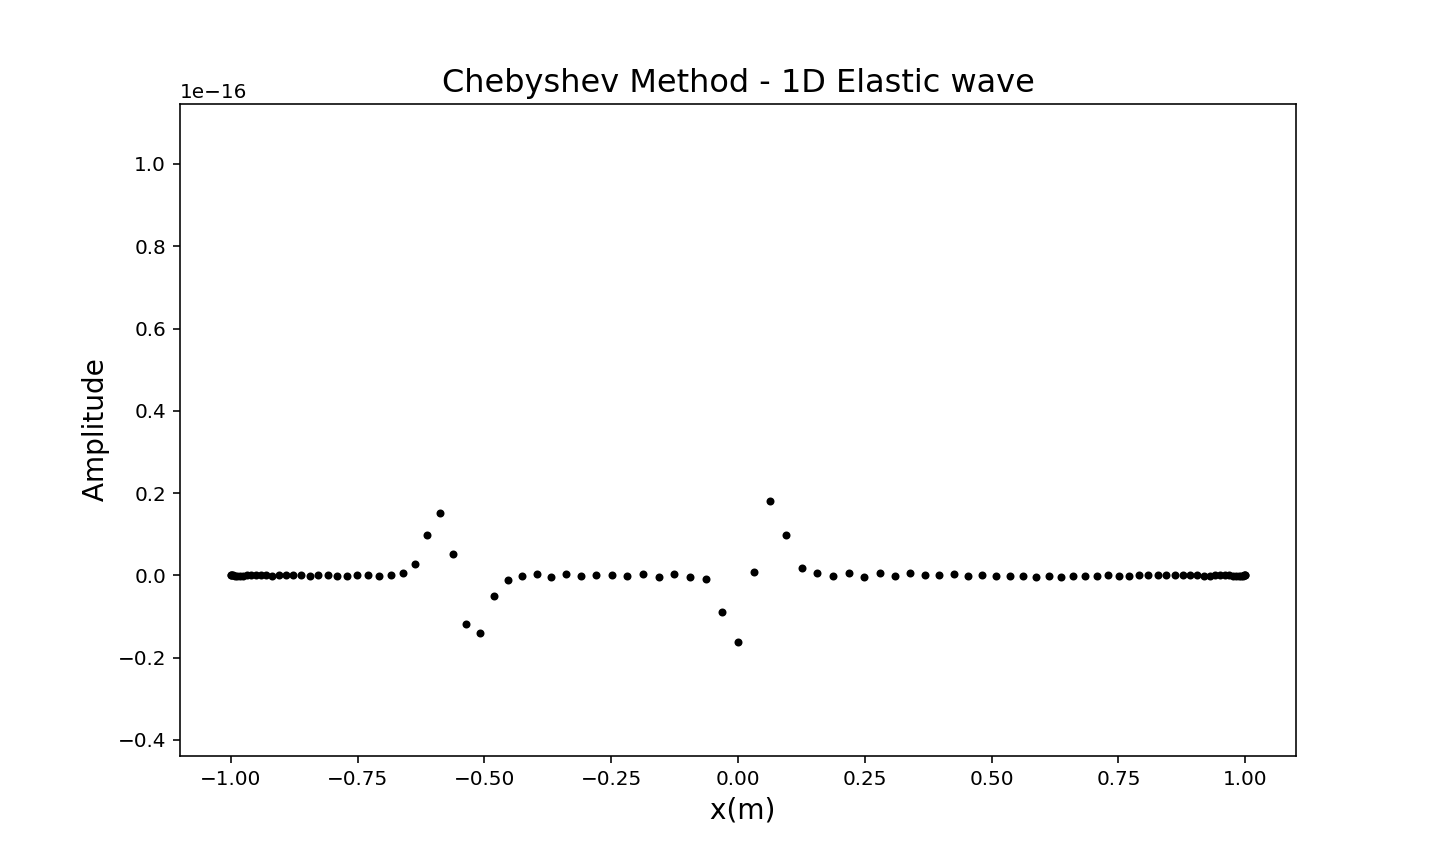

KeyboardInterrupt: 

In [88]:
# initialization of pressure fields
p = np.zeros(nx+1) 
pnew = np.zeros(nx+1)
pold = np.zeros(nx+1)
d2p  = np.zeros(nx+1) 


iplot = 20        # Snapshot frequency

# Show the plots in the Notebook.
plt.switch_backend("nbagg")

# Initialize animated plot
# ---------------------------------------------------------------
D,x = cheb(nx)
plt.figure(figsize=(10,6))
line = plt.plot(x, p, 'k.', lw=2)
plt.title('Chebyshev Method - 1D Elastic wave', size=16)
plt.xlabel(' x(m)', size=14)
plt.ylabel(' Amplitude ', size=14)

plt.ion() # set interective mode
plt.show()
# ---------------------------------------------------------------



# Time extrapolation
# ---------------------------------------------------------------
# Differentiation matrix
for it in range(nt):
    # Space derivatives
    dp = np.dot(D, p.T)
    dp = muu/rhoo * dp
    dp = D @ dp
    
    # Time extrapolation 
    pnew = 2*p - pold + np.transpose(dp) * dt**2
    
    # Source injection
    pnew = pnew + sg*src[it]*dt**2/rhoo
    
    # Remapping
    pold, p = p, pnew
    p[0] = 0; p[nx] = 0 # set boundaries pressure free 
    
    
    # Animation plot. Display solution
    if not it % iplot: 
        for l in line:
            l.remove()
            del l               
            
        # -------------------------------------- 
        # Display lines
        line = plt.plot(x, p, 'k.', lw=1.5)
        plt.gcf().canvas.draw()